In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mplsoccer import Pitch, VerticalPitch
from highlight_text import ax_text


import json 
from itertools import chain
import seaborn as sn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
from scipy import optimize as op
from scipy.spatial import ConvexHull

hfont = {'fontname':'Georgia'}



In [2]:

match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039] 

folder_path = os.path.join(os.getcwd(), 'corners')

#for increasing number of samples - all the corners that the home team in every games takes are assumed to be *conceded* by the OPPONENT
# & all the corners that the away team in every games takes are assumed to be *taken by* the OPPONENT
def read_csv_files(id_list):
    """
    read_csv_files(id_list)
    
    given a list of Skill corner match ids, the function reads files named {id}_home_*.csv/{id}_away_*.csv, 
    containing 10 seconds clip from when the ball was detected closest to any corner.
    
    Parameters
    -----------
    
    id_list (list): List of skill conrer match ids.
 
    Returns
    -----------
    
    defense_data (list): List of dataframes where the OPPONENT team was defending a corner 
    offense_data (list): List of dataframes where the OPPONENT team was taking a corner 
    defensive_files (list): List of file paths for OPPONENT team's defensive corners
    offensive_files (list): List of file paths for OPPONENT team's offensive corners
    
    """    
    defensive_files = []
    offensive_files = []

    for id in id_list:
        defensive_files.extend(glob.glob(os.path.join(folder_path, f"{id}_home_*.csv")))
        offensive_files.extend(glob.glob(os.path.join(folder_path, f"{id}_away_*.csv")))

    defense_data = []
    for file in defensive_files:
        data = pd.read_csv(file)
        defense_data.append(data)

    offense_data = []
    for file in offensive_files:
        data = pd.read_csv(file)
        offense_data.append(data)


    return defense_data, offense_data, defensive_files, offensive_files

defensive_list, offensive_list, defensive_files, offensive_files = read_csv_files(match_ids)



Find the closest corner to the ball position. Just keeping one of the if/else checks should be sufficient as well.

In [3]:
def get_closest_corner(dataframe, defensive_flag):
    """
    get_closest_corner(dataframe, defensive_flag)
    
    for a given dataframe, the function checks the location of the ball in the first row of the dataframe 
    and returns an integer denoting which corner of the pitch the ball was closest to.
    
    *OPPONENT* team is assumed to be attacking towards the goal in the (0,0) - (0,68) end.
    
    Parameters
    -----------
    
    dataframe (pd dataframe): dataframe created using kloppy for skillcorner data 
    defensive_flag (bool): True denotes that opponent team was defending a corner
    
    Returns
    -----------
    
    closest_flag (int): 1: ball closest to corner (105, 0) or (0, 68), 2: ball closest to corner (105, 68) or (0, 0)
    
    """    
    x, y = dataframe.iloc[0][["ball_x","ball_y"]].values

    if defensive_flag:

        distances = [
            math.sqrt((x - 105)**2 + y**2),    # Distance to (105, 0)
            math.sqrt((x - 105)**2 + (y - 68)**2)  # Distance to (105, 68)
        ]

    else:
        distances = [
            
            math.sqrt(x**2 + (y - 68)**2),     # Distance to (0, 68)
            math.sqrt(x**2 + y**2)             # Distance to (0, 0)
        ]


    #flags - if you are facing towards either side goals - 1 is the corner towards your left , 2 towards your right
    closest_flag = distances.index(min(distances)) + 1
    return closest_flag


For the opposition team - how many corner situations they have had from each side - for/against 

In [4]:
def corner_and_direction_count(corner_list, defensive_flag):
    """
    corner_and_direction_count(corner_list, defensive_flag)
    
    for the given list of dataframes the function returns the count of corners taken from either direction and a list enumerating the same.
    
    Parameters
    -----------
    
    corner_list (list): list of pandas dataframes
    defensive_flag (bool): True denotes that opponent team was defending a corner
    
    Returns
    -----------
    
    corner_counter (dict): Contains keys 'from_left' and 'from_right' with the count of corners taken from either end
    attacking_corner_directions (list): Contains either integer 1 or 2. 1 denotes the corner being taken from the left, 2 from the right.
    
    """  
       
    corner_counter = {}
    corner_directions = []

    for corners in corner_list:

        direction = get_closest_corner(corners, defensive_flag)
        corner_directions.append(direction)
        
        if direction == 1:
            corner_counter['from_left'] = corner_counter.get('from_left', 0) + 1
        
        else:
            corner_counter['from_right'] = corner_counter.get('from_right', 0) + 1

    return corner_counter, corner_directions

attacking_corner_counter = {}
defensive_corner_counter = {}
attacking_corner_directions = []
defensive_corner_directions = []

attacking_corner_counter, attacking_corner_directions = corner_and_direction_count(offensive_list, False)
defensive_corner_counter, defensive_corner_directions = corner_and_direction_count(defensive_list, True)

print("Corners taken by the opponent: ", attacking_corner_counter)
print("Corners conceded by the opponent", defensive_corner_counter)

Corners taken by the opponent:  {'from_left': 14, 'from_right': 7}
Corners conceded by the opponent {'from_left': 6, 'from_right': 9}


In [5]:
def get_goalkeeper(matchdata):
    """
    get_goalkeeper(matchdata)
    
    extracts the Goalkeeper jersey number from Skillcorner's match_data json file & returns it in the format "home_#jersey" & "away_#jersey"
    
    Parameters
    -----------
    
    matchdata (json): loaded json
    
    Returns
    -----------
    
    home_gk (str): "home_#jersey"
    away_gk (str):  "away_#jersey"
    
    """  

    home_team_id = matchdata['home_team']['id']
    away_team_id = matchdata['away_team']['id']

    home_gk = None
    away_gk = None
    
    for player in matchdata['players']:
        if (player['player_role']['name'] == "Goalkeeper") and (player["start_time"] == "00:00:00"):
            
            if player['team_id'] == home_team_id:
                home_gk = ("home_" + str(player['number']))
            
            else:
                away_gk = ("away_" + str(player['number']))
        
    return home_gk, away_gk


def find_corner_takers(corner_list,files_list,defensive_flag, path_to_files):

    """
    find_corner_takers(corner_list,files_list,defensive_flag, path_to_files)
    
    extracts the information about overall no. of corners, takers & their count & goal keeper info for all games in the corner_list parameter
    
    Parameters
    -----------
    
    corner_list (list): List of dataframes containing corner sequences
    files_list (list): List of csv file paths to the saved corner sequences
    defensive_flag (bool): True denotes that opponent team was defending a corner
    path_to_files (str): file path where all the skillcorner data is stored

    Returns
    -----------
    
    players (dict): A dict with corner taker's name as key and the number of corners taken as value
    goal_keepers (list):  List of all goalkeepers ("home_#jersey" & "away_#jersey") for each entry in the corner_list
    corner_directions (dict): Dict with 'from_left' or 'from_right' as key, number of corners from each side as value
    total_corners (int): Total corners across all sequences found in the corner_list
    """  
      
    players = {}
    corner_directions = {'from_left' : {}, 'from_right' : {}}
    goal_keepers = []
    total_corners = 0

    if defensive_flag:
        search_string = "_home"

    else:
        search_string = "_away"

    for i in range(len(files_list)):
        id = files_list[i].split(search_string)[0].split("\\")[-1]

        tracking_file = os.path.join(path_to_files, str(id) + '\\structured_data.json')
        matchdata_file = os.path.join(path_to_files, str(id) + '\\match_data.json')

        tf = open(tracking_file)
        tracking_data = json.load(tf) 

        mf = open(matchdata_file)
        matchdata = json.load(mf) 

        if defensive_flag:
            _, away_gk =  get_goalkeeper(matchdata)

            direction = get_closest_corner(corner_list[i], defensive_flag)
            
            goal_keepers.append(away_gk)

        else:
            home_gk, _ = get_goalkeeper(matchdata)
            direction = get_closest_corner(corner_list[i], defensive_flag)
            goal_keepers.append(home_gk)

        total_corners+=1

        #find player tracked closest to the corner arc
        player_trackable_id = tracking_data[corner_list[i].iloc[0]['frame_id']]['possession']['trackable_object']
        
        
        for player in matchdata['players']:
            if player['trackable_object'] == player_trackable_id:
                
                player_name = player['first_name'] + " " + player['last_name']
                players[player_name] = players.get(player_name, 0) + 1

                if direction == 1:
                    corner_directions['from_left'][player_name] = corner_directions['from_left'].get(player_name, 0) + 1

                else:
                    corner_directions['from_right'][player_name] = corner_directions['from_right'].get(player_name, 0) + 1


    return players, goal_keepers, corner_directions, total_corners

Currently not an efficient search - takes about 40 seconds or so. Can be made faster by storing player trackable_object separately, rather than acccessing the tracking data every time.

In [6]:
file_path = 'C:\\Users\\mishr\\Desktop\\fbref\\tracking data\\opendata-master\\data\\matches'

self_corner_takers, gk_for_ac, self_corner_directions, total_corners_conceded = find_corner_takers(defensive_list,defensive_files,True, file_path)
print("Total corners taken against opposition: ", total_corners_conceded)
print("Corner takers against opposition: ", self_corner_takers)
print("Directions for corner takers against opposition: ", self_corner_directions)


opposition_corner_takers, gk_for_dc, opposition_corner_directions, total_corners_taken = find_corner_takers(offensive_list,offensive_files,False, file_path)
print("Total corners taken by the opposition: ", total_corners_taken)
print("Opposition corner takers: ",opposition_corner_takers)
print("Directions for opposition corner: ", opposition_corner_directions)

Total corners taken against opposition:  15
Corner takers against opposition:  {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}
Directions for corner takers against opposition:  {'from_left': {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}, 'from_right': {}}
Total corners taken by the opposition:  21
Opposition corner takers:  {'Ferland Mendy': 1}
Directions for opposition corner:  {'from_left': {'Ferland Mendy': 1}, 'from_right': {}}


In [7]:
#uncomment the below code to visualize the trajectory of the ball for all corner situations
# for i in range(len(offensive_list)):

#         pitch = Pitch(pitch_color='grass',pitch_type='custom',
#                 pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

#         fig, ax = pitch.draw(figsize=(14, 12))

#         fig.set_facecolor('#4a8a32')

#         ax.plot( offensive_list[i][['ball_x']].dropna().values, 68 - offensive_list[i][['ball_y']].dropna().values, 'b.', MarkerSize=10, zorder=3)
        

In [8]:
def get_x_y_columns(dataframe, string_search):
    
    """
    get_x_y_columns(dataframe, string_search)
    
    Gets all the columns with x,y coordinates & columns with velocity in the x,y directions for all players in either the home or the away team

    Parameters
    -----------
    
    dataframe (pandas dataframe): Pandas dataframe in the kloppy format
    string_search (str): column name to look for, possible value : 'home_' , 'away_'
    
    Returns
    -----------
    
    x_cols (list): List with all columns with X coordinates
    y_cols (list):  List with all columns with Y coordinates
    x_velocity (list): List with all columns with velocity in the X direction
    y_velocity (list): List with all columns with velocity in the Y direction
    
    """  

    x_cols = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_x')]
    y_cols = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_y')]

    x_velocity = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_vx')]
    y_velocity = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_vy')]

    return x_cols, y_cols, x_velocity, y_velocity
 

In [9]:
def get_best_frame(list_dataframe, defensive_flag, min_opp_players):

    """
    get_best_frame(list_dataframe, defensive_flag, min_opp_players)

    Goes through the list of dataframes containing attacking or defending corner frames & picks the frame with most number of Opposition players found.
    The idea is that the frame with most number of Opposition players, be it during an attacking corner or a defensive one, will give the most information about how they set up.

    Parameters
    -----------
    
    list_dataframe (list): Pandas dataframe in the kloppy format
    defensive_flag (bool): True denotes that opponent team was defending a corner
    min_opp_players (int): Minimum number of Opponent's players to look for in every frame
    
    Returns
    -----------
    
    list_best_frames (list): A list of pandas series, containing the rows from dataframes where more than "min_opp_players" were found
    home_columns_list (list): List with all columns with (X,Y) coordinates for the home team in the dataframe (assumed to be the team playing against the opposition)
    away_columns_list (list): List with all columns with (X,Y) coordinates for the away team in the dataframe (assumed to be the opposition team)
    home_velocity_columns (list):  List with all columns with velocities in the (X,Y) coordinates for the home team in the dataframe (assumed to be the team playing against the opposition)
    away_velocity_columns (list): List with all columns with velocities in the (X,Y) coordinates for the away team in the dataframe (assumed to be the opposition team)
    selected_corner_ids (list): List with the index of entries from the list_dataframe parameter, where players more than "min_opp_players" were found
    
    """  
     
    selected_corner_ids = []

    if defensive_flag:
        final_third_line = 88.5

    else:
        final_third_line = 16.5
    
    list_best_frames = []
    home_columns_list = []
    away_columns_list = []

    home_velocity_columns = []
    away_velocity_columns = []

    max_score_row_index = None

    for i in range(len(list_dataframe)):

        home_x, home_y, home_x_vel, home_y_vel = get_x_y_columns(list_dataframe[i], 'home_')
    
        away_x, away_y, away_x_vel, away_y_vel = get_x_y_columns(list_dataframe[i], 'away_')               

        scores = []

        for _, row in list_dataframe[i].iterrows():
            score = 0
            
            for x_col, y_col in zip(away_x, away_y):
                
                if defensive_flag:
                    if pd.notna(row[x_col]) and pd.notna(row[y_col]) and row[x_col] > final_third_line and 14 <= row[y_col] <= 54:
                        score += 1

                else:
                    if pd.notna(row[x_col]) and pd.notna(row[y_col]) and row[x_col] < final_third_line and 14 <= row[y_col] <= 54:
                        score += 1
            
            scores.append(score)
                
        if max(scores) > min_opp_players:
            
            # Access the row with max. opposition players in the box
            max_score_row_index = max(range(len(scores)), key=scores.__getitem__)

            
            list_best_frames.append(list_dataframe[i].loc[max_score_row_index])
            home_columns_list.append((home_x, home_y))
            away_columns_list.append((away_x, away_y))

            home_velocity_columns.append((home_x_vel, home_y_vel))
            away_velocity_columns.append((away_x_vel, away_y_vel))

            selected_corner_ids.append(i)


    return list_best_frames, home_columns_list, away_columns_list, home_velocity_columns, away_velocity_columns, selected_corner_ids

In [10]:
#The naming is respective to the corners faced by the "OPPOSITION"
#Opposition's Attacking Corners - "ac"
#Opposition's Defending Corner - "dc"

#Columns representing Team X's players - "team_x_cols"
#Columns representing Oppositons's players  - "opp_cols"

min_no_of_opposition_players_in_frame = 3

opp_best_defensive_frames, team_x_cols_dc, opp_cols_dc, team_x_velocity_dc, opp_velocity_dc, defensive_corner_subset  = get_best_frame(defensive_list, True, min_no_of_opposition_players_in_frame)

opp_best_attacking_frames, team_x_cols_ac, opp_cols_ac, team_x_velocity_ac, opp_velocity_ac, attacking_corner_subset= get_best_frame(offensive_list, False, min_no_of_opposition_players_in_frame)

In [11]:
def filter_corner_direction_entries(entries, indices):

    """
    filter_corner_direction_entries(entries, indices)
    
    Subsets the list of corner directions to contain only the directions of corners where most number of Opposition players have been found (and above the given threshold)

    Parameters
    -----------
    
    entries (list): 'attacking_corner_directions' list returned by the function corner_and_direction_count
    indices (list): 'selected_corner_ids' returned by the function get_best_frame
    
    Returns
    -----------
    
    filtered_entries (list): list containing the directions of corners selected by the function get_best_frame 

    """  

    filtered_entries = [entry for i, entry in enumerate(entries) if i in indices]
    return filtered_entries


In [12]:
attacking_corner_directions = filter_corner_direction_entries(attacking_corner_directions, attacking_corner_subset)

In [13]:
defensive_corner_directions = filter_corner_direction_entries(defensive_corner_directions, defensive_corner_subset)

We remove the opposition goalkeeper while analyzing opposition's defensive shape (for better clustering).

In [14]:
for i in range(len(opp_cols_dc)):

    gk_x, gk_y = gk_for_ac[i]+"_x", gk_for_ac[i]+"_y"
    
    if gk_x in opp_cols_dc[i][0]:
        opp_cols_dc[i][0].remove(gk_x)
    
    if gk_y in opp_cols_dc[i][1]:
        opp_cols_dc[i][1].remove(gk_y)
    

Visualizing the distance between the attackers & opposition defenders

In [15]:
# Idea still to be built upon, these distances could perhaps be used as features to detect zonal/man-marking systems during given corner situations,
# will need removing the corner.

'''
def euclidean_distance(point1, point2):

    """
    euclidean_distance(point1, point2)
    
    Finds the euclidean distance between 2 given points with x,y coordinates

    Parameters
    -----------
    
    point1/point2 (np array): x, y coordinates
     
    Returns
    -----------
    
    distance (float): euclidean distance between the 2 given points

    """  

    return np.linalg.norm(point1 - point2)

def euclidean_similarity(array1, array2):

    """
    euclidean_distance(point1, point2)
    
    Finds the closest points between the points in two different sets, using the linear sum assignment problem.
    for more info. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

    Parameters
    -----------
    
    array1/array1 (np array):
     
    Returns
    -----------
    
    sum_dist (float): the total cost of the assignment 
    sol_rows (list): An array of row indices indices giving the optimal assignment. 
    sol_cols (list): An array of corresponding column indices giving the optimal assignment

    """  

    num_points1 = array1.shape[0]
    num_points2 = array2.shape[0]
    
    cost_matrix = np.zeros((num_points1, num_points2))
    
    for i in range(num_points1):
        for j in range(num_points2):
            cost_matrix[i, j] = euclidean_distance(array1[i], array2[j])
    

    # Perform linear sum assignment and get mean squared distance
    sol_rows, sol_cols = op.linear_sum_assignment(cost_matrix)
    sum_dist = cost_matrix[sol_rows, sol_cols].sum()
    # updated_cost_matrix = cost_matrix[sol_rows, sol_cols]


    return sum_dist, sol_rows, sol_cols
'''


'''
#x and y coordinates of team's players across all frames for defensive corners
team_x_x_dc = []
team_x_y_dc = []

#x and y coordinates of opposition players while they are defending a corner situation
opp_all_x_dc = []
opp_all_y_dc = []

#uncomment the below code to visualize all  - currently just shows the 1st corner frame.
# for i in range(len(opp_best_defensive_frames)):
for i in range(1):
        pitch = Pitch(pitch_color='grass',pitch_type='custom',
                pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

        fig, ax = pitch.draw(figsize=(14, 12))

        fig.set_facecolor('#4a8a32')

        ax.plot( opp_best_defensive_frames[i][team_x_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][team_x_cols_dc[i][1]], 'b.', MarkerSize=10, zorder=3)
        
        team_x_x_dc.append(opp_best_defensive_frames[i][team_x_cols_dc[i][0]].dropna().values)
        team_x_y_dc.append(68 - opp_best_defensive_frames[i][team_x_cols_dc[i][1]].dropna().values)
         

        ax.plot( opp_best_defensive_frames[i][opp_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][opp_cols_dc[i][1]], 'r.', MarkerSize=10, zorder=3)
        opp_all_x_dc.append(opp_best_defensive_frames[i][opp_cols_dc[i][0]].dropna().values)
        opp_all_y_dc.append(68 - opp_best_defensive_frames[i][opp_cols_dc[i][1]].dropna().values)

        #stacking all the (x,y) points to change shape from 1D array to 2D array.
        attack_coord = np.column_stack((team_x_x_dc[i], team_x_y_dc[i]))
        defence_coord = np.column_stack((opp_all_x_dc[i], opp_all_y_dc[i]))

        #linear assignment problem       
        cost, sol_rows, sol_cols = euclidean_similarity(attack_coord, defence_coord)
        
        
        #overlaps best assignments
        # {
        
        for rows in range(len(sol_rows)):
                ax.plot((attack_coord[sol_rows[rows]][0],defence_coord[sol_cols][rows][0]),(attack_coord[sol_rows[rows]][1],defence_coord[sol_cols][rows][1]),color='black')
                
        plt.text(27,70,"Distance between the attacker & nearest marker : " + str(round(cost, 1)) + " meters",**hfont,color="white",size=17)

        # }
'''

'\n#x and y coordinates of team\'s players across all frames for defensive corners\nteam_x_x_dc = []\nteam_x_y_dc = []\n\n#x and y coordinates of opposition players while they are defending a corner situation\nopp_all_x_dc = []\nopp_all_y_dc = []\n\n#uncomment the below code to visualize all  - currently just shows the 1st corner frame.\n# for i in range(len(opp_best_defensive_frames)):\nfor i in range(1):\n        pitch = Pitch(pitch_color=\'grass\',pitch_type=\'custom\',\n                pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color=\'#c7d5cc\')\n\n        fig, ax = pitch.draw(figsize=(14, 12))\n\n        fig.set_facecolor(\'#4a8a32\')\n\n        ax.plot( opp_best_defensive_frames[i][team_x_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][team_x_cols_dc[i][1]], \'b.\', MarkerSize=10, zorder=3)\n        \n        team_x_x_dc.append(opp_best_defensive_frames[i][team_x_cols_dc[i][0]].dropna().values)\n        team_x_y_dc.append(68 - opp_best_defensive_fra

Extract x and y coordinates of players across all frames where opposition is Defending corners

In [16]:
#x and y coordinates of Team X's players while the "opposition" team is defending a corner situation
team_x_x_dc = []
team_x_y_dc = []

#x and y coordinates of opposition players while they are defending a corner situation
opp_all_x_dc = []
opp_all_y_dc = []

#velocity in the x & y directions of Team X's players while the "opposition" team is defending a corner situation
team_x_vx_dc = []
team_x_vy_dc = []

#velocity in the x & y directions of opposition players while they are defending a corner situation
opp_all_vx_dc = []
opp_all_vy_dc = []


for i in range(len(opp_best_defensive_frames)):
        
        team_x_x_dc.append(105 - opp_best_defensive_frames[i][team_x_cols_dc[i][0]].dropna().values)
        opp_all_x_dc.append(105 - opp_best_defensive_frames[i][opp_cols_dc[i][0]].dropna().values)

        team_x_vx_dc.append(opp_best_defensive_frames[i][team_x_velocity_dc[i][0]].dropna().values)
        team_x_vy_dc.append(opp_best_defensive_frames[i][team_x_velocity_dc[i][1]].dropna().values)

        opp_all_vx_dc.append(opp_best_defensive_frames[i][opp_velocity_dc[i][0]].dropna().values)
        opp_all_vy_dc.append(opp_best_defensive_frames[i][opp_velocity_dc[i][1]].dropna().values)

        #flip the y coordiantes, assuming that the corners are taken from only one side. - for increasing sample size.
        if defensive_corner_directions[i] == 2:

                team_x_y_dc.append(opp_best_defensive_frames[i][team_x_cols_dc[i][1]].dropna().values)
                opp_all_y_dc.append(opp_best_defensive_frames[i][opp_cols_dc[i][1]].dropna().values)  

        else:
                team_x_y_dc.append(68 - opp_best_defensive_frames[i][team_x_cols_dc[i][1]].dropna().values)
                opp_all_y_dc.append(68 - opp_best_defensive_frames[i][opp_cols_dc[i][1]].dropna().values)    

Extract x and y coordinates of players across all frames where opposition is Attacking corners

In [17]:

team_x_x_ac = []
team_x_y_ac = []

#x and y coordinates of opposition players while they are attacking during a corner situation
opp_all_x_ac = []
opp_all_y_ac = []

team_x_vx_ac = []
team_x_vy_ac = []

opp_all_vx_ac = []
opp_all_vy_ac = []

for i in range(len(opp_best_attacking_frames)):

        team_x_x_ac.append(opp_best_attacking_frames[i][team_x_cols_ac[i][0]].dropna().values)
        opp_all_x_ac.append(opp_best_attacking_frames[i][opp_cols_ac[i][0]].dropna().values)


        team_x_vx_ac.append(opp_best_attacking_frames[i][team_x_velocity_ac[i][0]].dropna().values)
        team_x_vy_ac.append(opp_best_attacking_frames[i][team_x_velocity_ac[i][1]].dropna().values)

        opp_all_vx_ac.append(opp_best_attacking_frames[i][opp_velocity_ac[i][0]].dropna().values)
        opp_all_vy_ac.append(opp_best_attacking_frames[i][opp_velocity_ac[i][1]].dropna().values)


        #flip the y coordiantes, assuming that the corners are taken from only one side. - for increasing sample size.
        if attacking_corner_directions[i] == 1:
                team_x_y_ac.append(opp_best_attacking_frames[i][team_x_cols_ac[i][1]].dropna().values)
                opp_all_y_ac.append(opp_best_attacking_frames[i][opp_cols_ac[i][1]].dropna().values)    

        else:
                team_x_y_ac.append(68 - opp_best_attacking_frames[i][team_x_cols_ac[i][1]].dropna().values)
                opp_all_y_ac.append(68 - opp_best_attacking_frames[i][opp_cols_ac[i][1]].dropna().values)   

Helper functions used to plot the clusters denoting player positions for corners

In [18]:
def unzip_list_of_lists(list_of_lists):
    return list(chain.from_iterable(list_of_lists))


def separate_points_by_label(points, labels):
    unique_labels = np.unique(labels)
    separated_arrays = []

    for label in unique_labels:
        label_points = np.array([point for point, lbl in zip(points, labels) if lbl == label])
        separated_arrays.append(label_points)

    return separated_arrays

def find_lengths(list_of_lists):
    lengths = [len(sublist) for sublist in list_of_lists]
    return lengths


def calculate_percentage_sizes(separated_arrays, points, avg_no_players):
    total_points = len(points)
    percentage_sizes = []

    for arr in separated_arrays:
        size = len(arr)
        percentage = (size / total_points) * avg_no_players
        percentage_sizes.append(percentage)

    return percentage_sizes

In [19]:
#Plots locations of the players when the corner is taken from the top left side of a vertical pitch & uses Kmeans to cluster them into a given number of clusters.
def plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, title, markers = None):
    
    # KMeans algorithm 
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=60).fit(coords)

    centers = np.array(kmeans_model.cluster_centers_)

    pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

    fig, ax = pitch.draw(figsize=(14, 12))

    fig.set_facecolor('#4a8a32')

    clustered_arrays = separate_points_by_label(coords, kmeans_model.labels_)

    for i, l in enumerate(kmeans_model.labels_):
        plt.plot(coords[i][1],105 - coords[i][0], color=colors[l], marker="o",ls='None')

    cluster_share = calculate_percentage_sizes(clustered_arrays, coords, avg_no_of_player_in_frame)

    for cluster_index in range(len(clustered_arrays)):
        hull = ConvexHull(clustered_arrays[cluster_index])


        for simplex in hull.simplices:
            plt.plot(clustered_arrays[cluster_index][simplex, 1], 105 - clustered_arrays[cluster_index][simplex, 0], colors[cluster_index])
        
        plt.text(centers[cluster_index][1] + 0.7,105 - centers[cluster_index][0] + 0.7,str(round(cluster_share[cluster_index], 1)),**hfont,color="black",size=21)

        
            
        plt.fill(clustered_arrays[cluster_index][hull.vertices,1], 105 - clustered_arrays[cluster_index][hull.vertices,0], 'grey', alpha=0.9)

    pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
    
    plt.scatter(centers[:,1], 105 - centers[:,0], marker="x", color='black', zorder=3)

    # plt.triplot(centers[:,1], 105 - centers[:,0], color='yellow', linewidth=2)

    plt.title(title, **hfont,color="black",size=21)

    plt.text(60,69,"* Corner taken from the left corner of this image.",color='black',size =15, **hfont)
    plt.text(60,66,"* number denotes the average number of players in each zone",color='black',size =15, **hfont)
    plt.text(60,63,"* x -> average player location in each zone",color='black',size =15, **hfont)
    
    return fig, ax



In [20]:
#Plots the center of the clusters & their average velocity - if provided (only for attacking corners)
def plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, title, velocity_coords = None, markers = None):
        
    # KMeans algorithm 
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=60).fit(coords)

    centers = np.array(kmeans_model.cluster_centers_)

    pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

    fig, ax = pitch.draw(figsize=(14, 12))

    fig.set_facecolor('#4a8a32')

    clustered_arrays = separate_points_by_label(coords, kmeans_model.labels_)

    if type(velocity_coords) == np.ndarray:
        clustered_velocity_arrays = separate_points_by_label(velocity_coords, kmeans_model.labels_)

        for clusters in range(len(clustered_velocity_arrays)):
            avg_vx = np.mean(clustered_velocity_arrays[clusters][:,0])
            avg_vy = np.mean(clustered_velocity_arrays[clusters][:,1])

            ax.quiver(centers[clusters][1], 105 - centers[clusters][0], avg_vy, avg_vx, color="red", scale_units='inches', scale=1.5,width=0.002,headlength=5,headwidth=8)


    pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)

    plt.scatter(centers[:,1], 105 - centers[:,0], marker="o", color='black', zorder=3)

    plt.title(title, **hfont,color="black",size=21)
    
    return fig, ax



(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Offensive set up"}>)

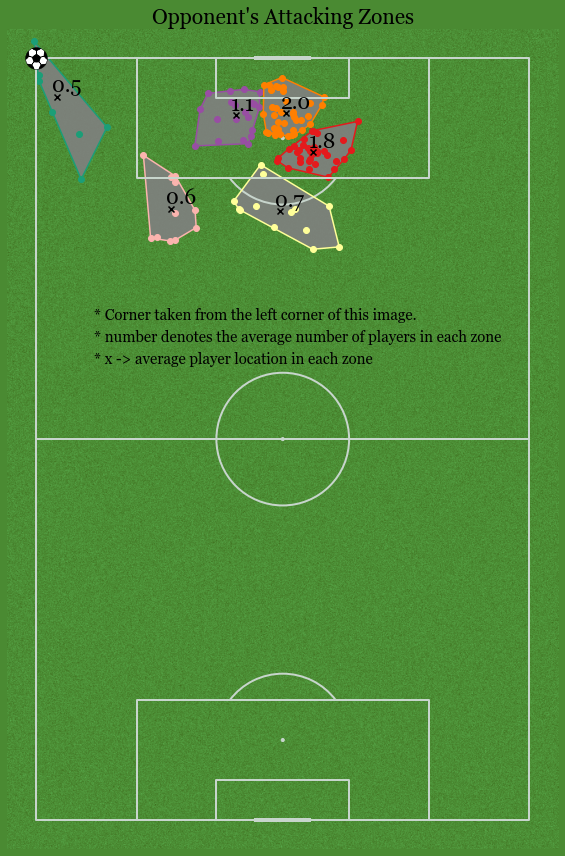

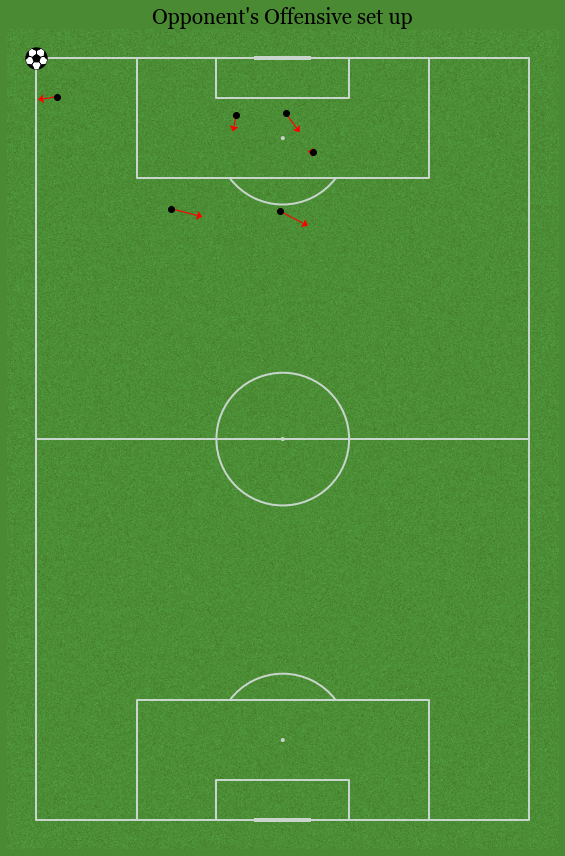

In [21]:
#All x,y coordinates of opposition players while they attack their corners in one list
list_opp_all_x_ac = unzip_list_of_lists(opp_all_x_ac)
list_opp_all_y_ac = unzip_list_of_lists(opp_all_y_ac)


list_opp_all_vx_ac = unzip_list_of_lists(opp_all_vx_ac)
list_opp_all_vy_ac = unzip_list_of_lists(opp_all_vy_ac)


avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_ac))

coords = np.column_stack((list_opp_all_x_ac, list_opp_all_y_ac))

coords_velocity = np.column_stack((list_opp_all_vx_ac, list_opp_all_vy_ac))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Attacking Zones")

plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Offensive set up", velocity_coords = coords_velocity)

Ideally we should be using the elbow method to decide the number of clusters for the given data.
The elbow method, used below, recommends using 4 clusters.
Since the data used for this analysis is not exactly accurate & contains ~approximate corner frames~ & also the fact that using 4 clusters doesn't help us gather any meaningful footballing inference, we opt to use 6 clusters, for Opposition's attacking as well as defensive positions.

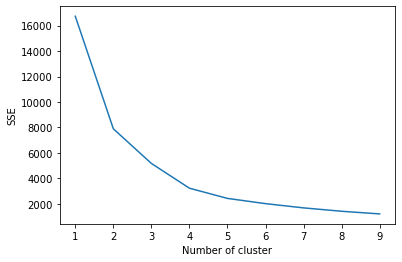

In [22]:
#Elbow method :

distance_to_closest_cluster = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(coords)
    distance_to_closest_cluster[k] = kmeans.inertia_
plt.figure()
plt.plot(list(distance_to_closest_cluster.keys()), list(distance_to_closest_cluster.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Defensive set up (GK removed)"}>)

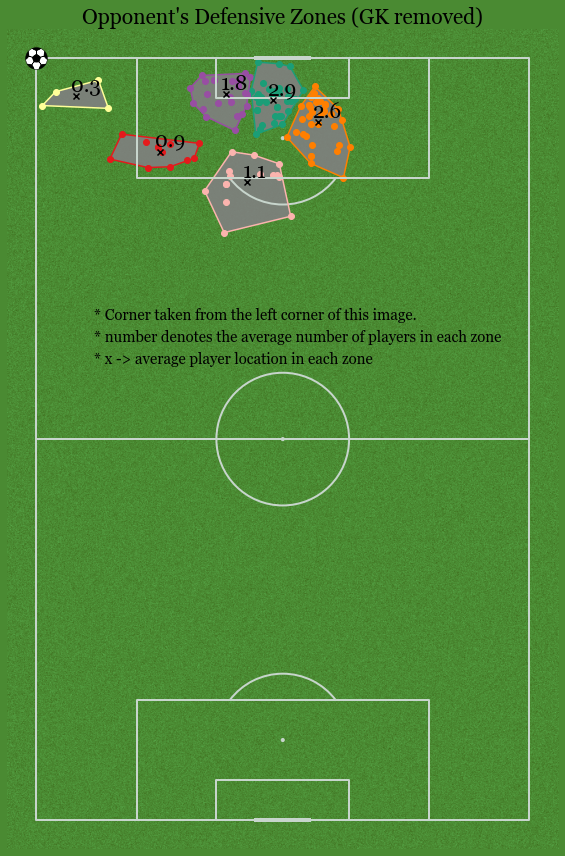

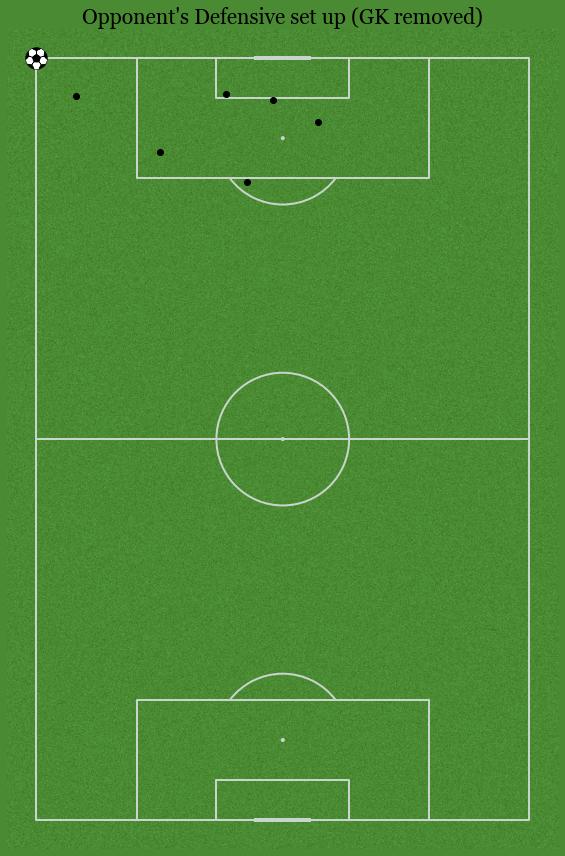

In [23]:
#All x,y coordinates of opposition players while they defend their corners in one list
list_opp_all_x_dc = unzip_list_of_lists(opp_all_x_dc)
list_opp_all_y_dc = unzip_list_of_lists(opp_all_y_dc)


list_opp_all_vx_dc = unzip_list_of_lists(opp_all_vx_dc)
list_opp_all_vy_dc = unzip_list_of_lists(opp_all_vy_dc)


avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_dc))

coords = np.column_stack((list_opp_all_x_dc, list_opp_all_y_dc))

coords_velocity = np.column_stack((list_opp_all_vx_dc, list_opp_all_vy_dc))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Defensive Zones (GK removed)")


plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Defensive set up (GK removed)")


In [24]:
print("Total corners taken against opposition: ", total_corners_conceded)
print("Corner takers against opposition: ", self_corner_takers)
print("Directions for corner takers against opposition: ", self_corner_directions)

print("Corners conceded by the opponent", defensive_corner_counter)


Total corners taken against opposition:  15
Corner takers against opposition:  {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}
Directions for corner takers against opposition:  {'from_left': {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}, 'from_right': {}}
Corners conceded by the opponent {'from_left': 6, 'from_right': 9}


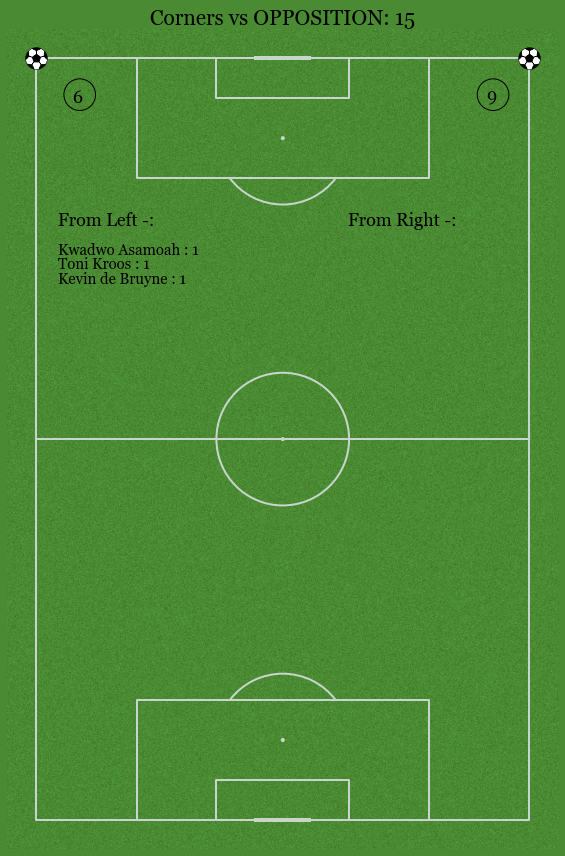

In [25]:

pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
        pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))

fig.set_facecolor('#4a8a32')

plt.title("Corners vs OPPOSITION: " + str(total_corners_conceded), **hfont,color="black",size=21)


#left side
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(62, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(63,99,str(defensive_corner_counter['from_left']),color='black',size =18, **hfont)

#right side
pitch.scatter(105, 0,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(5, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(6,99,str(defensive_corner_counter['from_right']),color='black',size =18, **hfont)



plt.text(65,82,"From Left -: ",color='black',size =18, **hfont)

left_side_takers = list(self_corner_directions['from_left'].keys())
for i in range(len(left_side_takers)):
        plt.text(65,78 - 2 * i,left_side_takers[i] + " : " + str(self_corner_directions['from_left'][left_side_takers[i]]),color='black',size =15, **hfont)




plt.text(25,82,"From Right -: ",color='black',size =18, **hfont)

right_side_takers = list(self_corner_directions['from_right'].keys())
for i in range(len(right_side_takers)):
        plt.text(25,78 - 2 * i,right_side_takers[i] + " : " + str(right_side_takers['from_right'][right_side_takers[i]]),color='black',size =15, **hfont)



In [26]:

print("Total corners taken by the opposition: ", total_corners_taken)
print("Opposition corner takers: ",opposition_corner_takers)
print("Directions for opposition corner: ", opposition_corner_directions)


print("Corners taken by the opponent: ", attacking_corner_counter)

Total corners taken by the opposition:  21
Opposition corner takers:  {'Ferland Mendy': 1}
Directions for opposition corner:  {'from_left': {'Ferland Mendy': 1}, 'from_right': {}}
Corners taken by the opponent:  {'from_left': 14, 'from_right': 7}


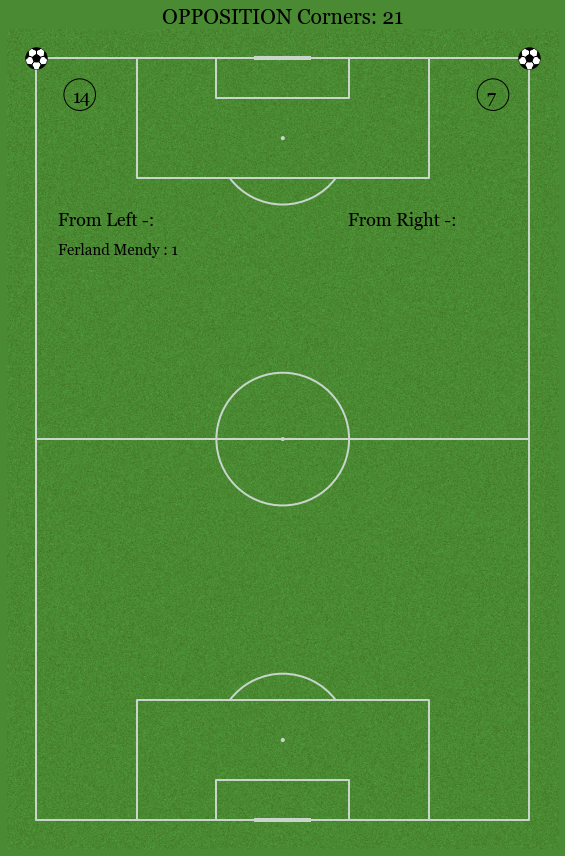

In [27]:

pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
        pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))

fig.set_facecolor('#4a8a32')

plt.title("OPPOSITION Corners: " + str(total_corners_taken), **hfont,color="black",size=21)


#left side
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(62, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(63,99,str(attacking_corner_counter['from_left']),color='black',size =18, **hfont)

#right side
pitch.scatter(105, 0,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(5, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(6,99,str(attacking_corner_counter['from_right']),color='black',size =18, **hfont)



plt.text(65,82,"From Left -: ",color='black',size =18, **hfont)

left_side_takers = list(opposition_corner_directions['from_left'].keys())
for i in range(len(left_side_takers)):
        plt.text(65,78 - 2 * i,left_side_takers[i] + " : " + str(opposition_corner_directions['from_left'][left_side_takers[i]]),color='black',size =15, **hfont)




plt.text(25,82,"From Right -: ",color='black',size =18, **hfont)

right_side_takers = list(opposition_corner_directions['from_right'].keys())
for i in range(len(right_side_takers)):
        plt.text(25,78 - 2 * i,right_side_takers[i] + " : " + str(right_side_takers['from_right'][right_side_takers[i]]),color='black',size =15, **hfont)

